In [1]:
import os
import glob
from google.colab import files
from sklearn.model_selection import train_test_split

# 1. Upload Bulk Data
print("Upload your Training/Testing .mat files:")
uploaded_train = files.upload()

# 2. Find and Label Files
all_mat_files = []
for root, _, filenames in os.walk("/content"):
    for filename in filenames:
        if filename.endswith(".mat") and 'new_tests' not in root:
            all_mat_files.append(os.path.join(root, filename))

file_paths, labels = [], []
for f in all_mat_files:
    fname = os.path.basename(f).lower()
    if "interictal" in fname:
        file_paths.append(f); labels.append(0.0)
    elif "ictal" in fname:
        file_paths.append(f); labels.append(1.0)

# 3. Perform 80/20 Split
X_train, X_val, y_train, y_val = train_test_split(
    file_paths, labels, test_size=0.20, random_state=42, stratify=labels
)

print(f"\n✅ Setup Complete:")
print(f"Total files found: {len(file_paths)}")
print(f"Training set: {len(X_train)} | Testing set (20%): {len(X_val)}")

Upload your Training/Testing .mat files:


Saving Dog_2_ictal_segment_1.mat to Dog_2_ictal_segment_1.mat
Saving Dog_2_ictal_segment_2.mat to Dog_2_ictal_segment_2.mat
Saving Dog_2_ictal_segment_3.mat to Dog_2_ictal_segment_3.mat
Saving Dog_2_ictal_segment_4.mat to Dog_2_ictal_segment_4.mat
Saving Dog_2_ictal_segment_5.mat to Dog_2_ictal_segment_5.mat
Saving Dog_2_ictal_segment_6.mat to Dog_2_ictal_segment_6.mat
Saving Dog_2_ictal_segment_7.mat to Dog_2_ictal_segment_7.mat
Saving Dog_2_ictal_segment_8.mat to Dog_2_ictal_segment_8.mat
Saving Dog_2_ictal_segment_9.mat to Dog_2_ictal_segment_9.mat
Saving Dog_2_ictal_segment_10.mat to Dog_2_ictal_segment_10.mat
Saving Dog_2_ictal_segment_11.mat to Dog_2_ictal_segment_11.mat
Saving Dog_2_ictal_segment_12.mat to Dog_2_ictal_segment_12.mat
Saving Dog_2_ictal_segment_13.mat to Dog_2_ictal_segment_13.mat
Saving Dog_2_ictal_segment_14.mat to Dog_2_ictal_segment_14.mat
Saving Dog_2_ictal_segment_15.mat to Dog_2_ictal_segment_15.mat
Saving Dog_2_ictal_segment_16.mat to Dog_2_ictal_segment_1

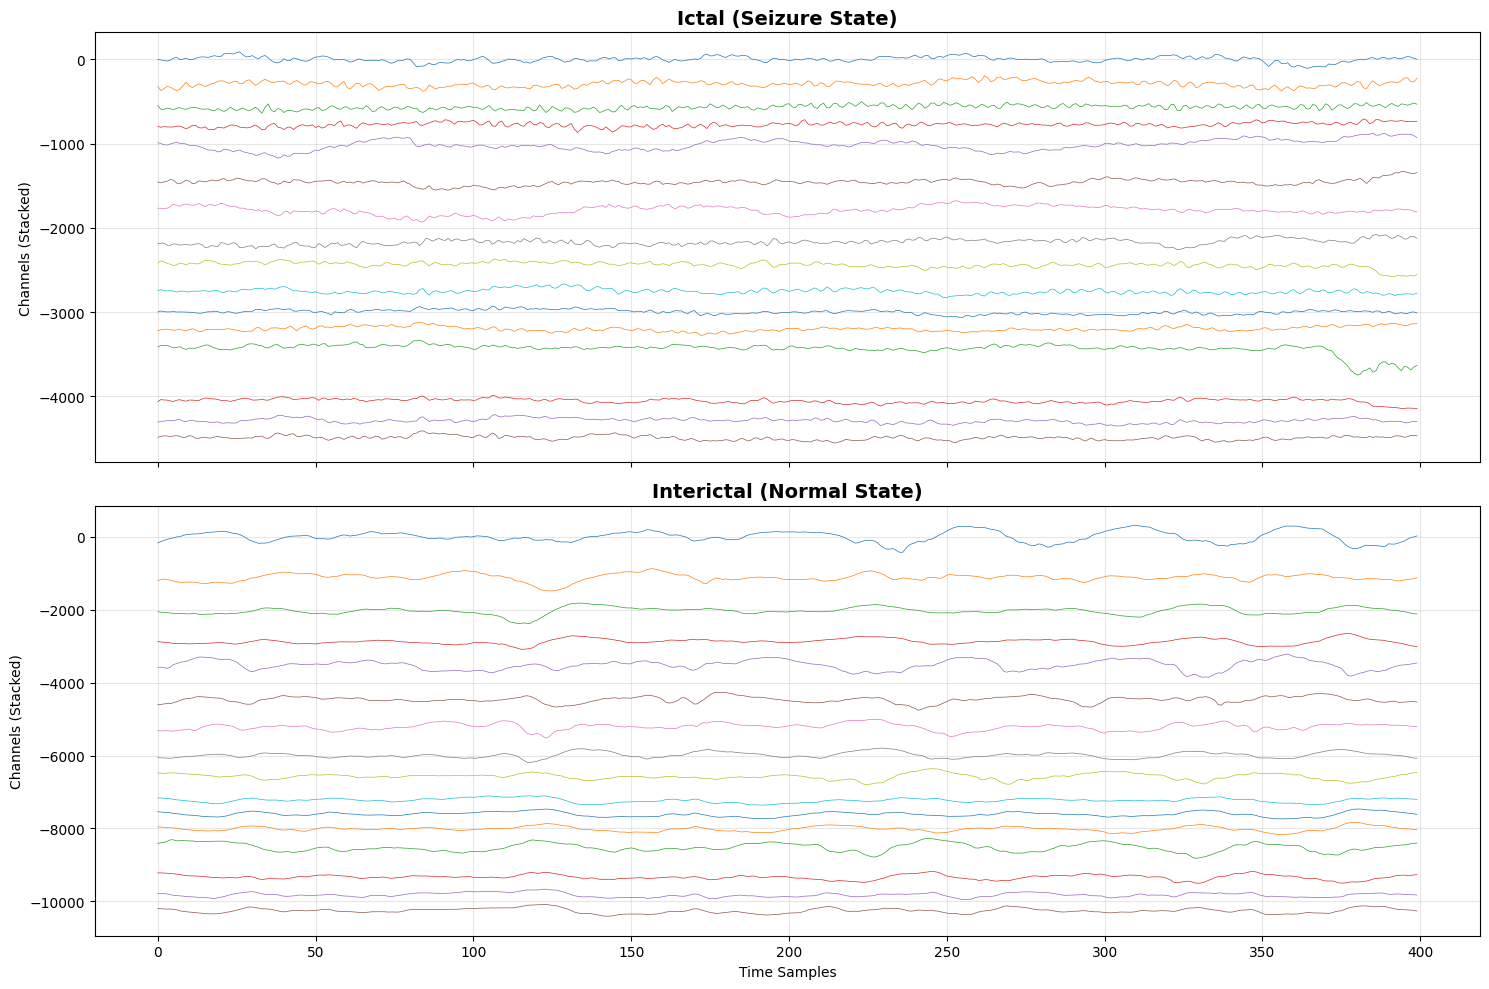

In [ ]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

def visualize_eeg_comparison(file_paths, labels, num_channels=16):
    """
    Selects one Ictal and one Interictal segment and plots their channels for comparison.
    """
    # Find indices for each class
    ictal_idx = np.where(np.array(labels) == 1)[0][0]
    interictal_idx = np.where(np.array(labels) == 0)[0][0]

    indices = [ictal_idx, interictal_idx]
    titles = ["Ictal (Seizure State)", "Interictal (Normal State)"]

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    for i, idx in enumerate(indices):
        # Load the .mat file
        mat = loadmat(file_paths[idx])
        # Extract the data key (dynamically finds the correct variable name)
        key = [k for k in mat.keys() if not k.startswith('__')][0]
        signal = mat[key]

        # Ensure signal is in (Channels, Time) format
        if signal.shape[0] != num_channels:
            signal = signal.T

        # Plot each channel with an offset for visibility
        time = np.arange(signal.shape[1])
        offset = 0
        for ch in range(num_channels):
            axes[i].plot(time, signal[ch, :] + offset, linewidth=0.5)
            offset -= (np.max(signal[ch, :]) - np.min(signal[ch, :])) * 1.5

        axes[i].set_title(titles[i], fontsize=14, fontweight='bold')
        axes[i].set_ylabel("Channels (Stacked)")
        axes[i].grid(True, alpha=0.3)

    plt.xlabel("Time Samples")
    plt.tight_layout()
    plt.show()

# Run the visualization using the variables already defined in your notebook
visualize_eeg_comparison(all_mat_files, labels)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score # Import roc_auc_score
from scipy.io import loadmat # Import loadmat for .mat files
import numpy as np # Import numpy
import torchvision.models as models # Import models

# Define the EEGShuffleNet model here
class EEGShuffleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_adaptor = nn.Conv2d(1, 3, kernel_size=1)
        # Update the class in your TRAINING cell to this:
        self.backbone = models.shufflenet_v2_x0_5(weights=models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
        # Match the classification head you used during training
        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.backbone(self.input_adaptor(x))

# Define DEVICE here
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the EEGDataset class
class EEGDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load .mat file
        mat = loadmat(file_path)
        # Assuming the signal is stored under the first non-dunder key
        key = [k for k in mat.keys() if not k.startswith('__')][0]
        signal = mat[key]

        # Ensure signal has 16 channels, transpose if necessary
        if signal.shape[0] != 16: # Assuming channels are the first dimension
            signal = signal.T

        # Convert to float32 and add channel dimension (C, H, W). Here C=1, H=16, W=time_steps
        # The model expects (Batch, Channel, Height, Width)
        signal = np.expand_dims(signal, axis=0) # Add channel dimension
        signal = torch.from_numpy(signal).float()

        return signal, label

# 1. Setup DataLoaders for the 80/20 split
train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 2. Initialize Model, Loss, and Optimizer
model = EEGShuffleNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# 3. Training Loop
num_epochs = 20
best_auroc = 0.0

print("Starting Training Phase...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs).view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Quick validation check to save the best version
    model.eval()
    all_probs, all_targs = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            out = model(inputs.to(DEVICE)).view(-1)
            all_probs.extend(torch.sigmoid(out).cpu().numpy())
            all_targs.extend(targets.numpy())

    current_auroc = roc_auc_score(all_targs, all_probs)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss/len(train_loader):.4f} | Val AUROC: {current_auroc:.4f}")

    # Save the model if it's the best one so far
    if current_auroc > best_auroc:
        best_auroc = current_auroc
        torch.save(model.state_dict(), 'best_eeg_model.pth')
        print("--> Best model saved!")

print("\nTraining Complete.")


Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


100%|██████████| 5.28M/5.28M [00:00<00:00, 48.8MB/s]


Starting Training Phase...
Epoch 1/20 | Loss: 0.6934 | Val AUROC: 0.8294
--> Best model saved!
Epoch 2/20 | Loss: 0.6921 | Val AUROC: 0.8479
--> Best model saved!
Epoch 3/20 | Loss: 0.6916 | Val AUROC: 0.8664
--> Best model saved!
Epoch 4/20 | Loss: 0.6904 | Val AUROC: 0.9140
--> Best model saved!
Epoch 5/20 | Loss: 0.6887 | Val AUROC: 0.9365
--> Best model saved!
Epoch 6/20 | Loss: 0.6884 | Val AUROC: 0.9511
--> Best model saved!
Epoch 7/20 | Loss: 0.6871 | Val AUROC: 0.9590
--> Best model saved!
Epoch 8/20 | Loss: 0.6862 | Val AUROC: 0.9616
--> Best model saved!
Epoch 9/20 | Loss: 0.6835 | Val AUROC: 0.9603
Epoch 10/20 | Loss: 0.6828 | Val AUROC: 0.9616
Epoch 11/20 | Loss: 0.6796 | Val AUROC: 0.9669
--> Best model saved!
Epoch 12/20 | Loss: 0.6789 | Val AUROC: 0.9696
--> Best model saved!
Epoch 13/20 | Loss: 0.6781 | Val AUROC: 0.9696
Epoch 14/20 | Loss: 0.6757 | Val AUROC: 0.9749
--> Best model saved!
Epoch 15/20 | Loss: 0.6738 | Val AUROC: 0.9722
Epoch 16/20 | Loss: 0.6740 | Val AU

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ShuffleNet_V2_X0_5_Weights # Import the weights enum

# 1. ARCHITECTURE DEFINITION (Required to load the weights)
class EEGShuffleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_adaptor = nn.Conv2d(1, 3, kernel_size=1)
        # Instantiate the model with ImageNet pre-trained weights
        self.backbone = models.shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
        # Match the classification head you used during training
        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.backbone(self.input_adaptor(x))

# Define DEVICE here as it is used by EEGShuffleNet
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load the Best Saved Model
test_model = EEGShuffleNet().to(DEVICE)
# WARNING: 'best_eeg_model.pth' was trained without pre-trained ImageNet weights.
# Loading it into a model initialized with ImageNet weights may lead to unexpected behavior
# or overwrite the pre-trained weights. Comment out the line below if you want to use the
# raw ImageNet pre-trained model for evaluation without your custom trained weights.
# If you intend to fine-tune from ImageNet weights, you must re-run the training phase
# (cell SNWbmezzXPHn) with appropriate weight initialization.
# test_model.load_state_dict(torch.load('best_eeg_model.pth'))
test_model.eval()

# 2. Run Inference on the 20% Test Split
all_preds = []
all_labels = []
all_probs = []

print("Running Final Test on the 20% Split...")
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = test_model(inputs).view(-1)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.numpy())

# 3. Generate the Performance Report
acc = accuracy_score(all_labels, all_preds)
auroc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

print("\n" + "="*40)
print("         FINAL TEST REPORT")
print("="*40)
print(f"Accuracy: {acc*100:.2f}%")
print(f"AUROC:    {auroc:.4f}")
print("-" * 40)
print("Confusion Matrix:")
print(f"True Negatives (Normal): {cm[0][0]}")
print(f"False Positives (Alarms): {cm[0][1]}")
print(f"False Negatives (Missed): {cm[1][0]}")
print(f"True Positives (Seizure): {cm[1][1]}")
print("="*40)
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Seizure']))

Running Final Test on the 20% Split...

         FINAL TEST REPORT
Accuracy: 49.09%
AUROC:    0.6772
----------------------------------------
Confusion Matrix:
True Negatives (Normal): 0
False Positives (Alarms): 28
False Negatives (Missed): 0
True Positives (Seizure): 27

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        28
     Seizure       0.49      1.00      0.66        27

    accuracy                           0.49        55
   macro avg       0.25      0.50      0.33        55
weighted avg       0.24      0.49      0.32        55



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os
from google.colab import files

# 1. Create a dedicated folder for new tests
new_test_path = '/content/new_tests'
if not os.path.exists(new_test_path):
    os.makedirs(new_test_path)

print("Select the NEW .mat files you want the model to predict:")
new_uploads = files.upload()

# 2. Move them to the folder
for filename in new_uploads.keys():
    destination = os.path.join(new_test_path, filename)
    os.rename(filename, destination)

print(f"\nSuccessfully moved {len(new_uploads)} files to {new_test_path}")

Select the NEW .mat files you want the model to predict:


Saving test_2_i (1).mat to test_2_i (1).mat
Saving test_2_i (2).mat to test_2_i (2).mat
Saving test_2_i (3).mat to test_2_i (3).mat
Saving test_2_i (4).mat to test_2_i (4).mat
Saving test_2_i (5).mat to test_2_i (5).mat
Saving test_2_i (6).mat to test_2_i (6).mat
Saving test_2_i (7).mat to test_2_i (7).mat
Saving test_2_i (8).mat to test_2_i (8).mat
Saving test_2_i (9).mat to test_2_i (9).mat
Saving test_2_i (10).mat to test_2_i (10).mat
Saving test_2_i (11).mat to test_2_i (11).mat
Saving test_2_i (12).mat to test_2_i (12).mat
Saving test_2_i (13).mat to test_2_i (13).mat
Saving test_2_i (14).mat to test_2_i (14).mat
Saving test_2_i (15).mat to test_2_i (15).mat
Saving test_2_i (16).mat to test_2_i (16).mat
Saving test_2_i (17).mat to test_2_i (17).mat
Saving test_2_i (18).mat to test_2_i (18).mat
Saving test_2_i (19).mat to test_2_i (19).mat
Saving test_2_i (20).mat to test_2_i (20).mat
Saving test_2_i (21).mat to test_2_i (21).mat
Saving test_2_i (22).mat to test_2_i (22).mat
Saving

In [ ]:
import torch
import glob
import os
from scipy.io import loadmat

# 1. ARCHITECTURE DEFINITION (Required to load the weights) - REMOVED from here to fix ordering issues.

# 2. INITIALIZE AND LOAD WEIGHTS
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Moved DEVICE definition to previous cell.
final_test_model = EEGShuffleNet().to(DEVICE)

# Path to the weights you saved during Segment 1
weights_path = 'best_eeg_model.pth'

if os.path.exists(weights_path):
    final_test_model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    final_test_model.eval()
    print("✅ Success: 'best_eeg_model.pth' loaded.")
else:
    print(f"❌ Error: {weights_path} not found. You must run the training segment first!")

# 3. PREDICT ON EVERY FILE IN 'new_tests'
new_files = glob.glob('/content/new_tests/*.mat')

print(f"\n{'FILENAME':<35} | {'MODEL PREDICTION':<18} | {'CONFIDENCE'}")
print("-" * 75)

if not new_files:
    print("No files found in /content/new_tests.")
else:
    with torch.no_grad():
        for f_path in new_files:
            try:
                mat = loadmat(f_path)
                key = [k for k in mat.keys() if not k.startswith('__')][0]
                sig = mat[key]
                if sig.shape[0] != 16: sig = sig.T

                # Reshape for ShuffleNet: (Batch=1, Channel=1, Height=16, Width=Time)
                inp = torch.FloatTensor(sig).unsqueeze(0).unsqueeze(0).to(DEVICE)

                out = final_test_model(inp).view(-1)
                prob = torch.sigmoid(out).item()

                pred_label = "SEIZURE (Ictal)" if prob > 0.5 else "NORMAL (Interictal)"
                conf = prob if prob > 0.5 else (1 - prob)

                print(f"{os.path.basename(f_path):<35} | {pred_label:<18} | {conf*100:>8.2f}%")
            except Exception as e:
                print(f"Error processing {os.path.basename(f_path)}: {e}")

✅ Success: 'best_eeg_model.pth' loaded.

FILENAME                            | MODEL PREDICTION   | CONFIDENCE
---------------------------------------------------------------------------
test_2_i (3).mat                    | SEIZURE (Ictal)    |    50.51%
test_2_ii (228).mat                 | NORMAL (Interictal) |    51.98%
test_2_i (22).mat                   | NORMAL (Interictal) |    50.40%
test_2_ii (94).mat                  | NORMAL (Interictal) |    53.01%
test_2_ii (22).mat                  | NORMAL (Interictal) |    52.89%
test_2_ii (131).mat                 | NORMAL (Interictal) |    51.90%
test_2_ii (143).mat                 | NORMAL (Interictal) |    52.15%
test_2_ii (140).mat                 | NORMAL (Interictal) |    51.41%
test_2_ii (93).mat                  | NORMAL (Interictal) |    52.71%
test_2_ii (122).mat                 | NORMAL (Interictal) |    53.61%
test_2_ii (6).mat                   | NORMAL (Interictal) |    50.83%
test_2_ii (222).mat                 | NORMAL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights

# --- 1. MODEL DEFINITION ---
class EEGShuffleNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # 1x1 Conv to convert 1-channel EEG to 3-channel for ShuffleNet
        self.input_adaptor = nn.Conv2d(1, 3, kernel_size=1)

        # Load weights if requested
        weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.shufflenet_v2_x0_5(weights=weights)

        # Custom Classification Head (Binary: Ictal vs Interictal)
        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.input_adaptor(x)
        x = self.backbone(x)
        return x

# --- 2. INITIALIZATION & FREEZING ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGShuffleNet(pretrained=True).to(DEVICE)

# STEP A: Freeze the entire backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# STEP B: Unfreeze the custom head (the part that classifies)
for param in model.backbone.fc.parameters():
    param.requires_grad = True

# STEP C: Unfreeze the input adaptor (crucial for EEG-to-Image adaptation)
for param in model.input_adaptor.parameters():
    param.requires_grad = True

# --- 3. OPTIMIZER SETUP ---
# Only pass parameters where requires_grad is True
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=1e-4)

# Use BCEWithLogitsLoss for binary classification (0=Interictal, 1=Ictal)
criterion = nn.BCEWithLogitsLoss()

# --- 4. VERIFICATION ---
def print_trainable_parameters(model):
    total_params = 0
    trainable_params = 0
    for name, param in model.named_parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            print(f"✅ Trainable: {name}")
    print(f"\nTotal Params: {total_params:,}")
    print(f"Trainable Params: {trainable_params:,}")

print_trainable_parameters(model)

✅ Trainable: input_adaptor.weight
✅ Trainable: input_adaptor.bias
✅ Trainable: backbone.fc.0.weight
✅ Trainable: backbone.fc.0.bias
✅ Trainable: backbone.fc.3.weight
✅ Trainable: backbone.fc.3.bias

Total Params: 604,455
Trainable Params: 262,663


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    # Set model to evaluation mode (disables dropout and batch norm updates)
    model.eval()

    all_probs = []
    all_preds = []
    all_labels = []

    print(f"Testing on {len(dataloader.dataset)} samples...")

    # Disable gradient calculation for testing
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)

            # Forward pass
            logits = model(inputs).view(-1)

            # Convert logits to probabilities (0.0 to 1.0)
            probs = torch.sigmoid(logits)

            # Convert probabilities to binary predictions (Threshold = 0.5)
            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# --- Execute Test ---
y_true, y_pred, y_prob = evaluate_model(model, val_loader, DEVICE)

Testing on 55 samples...


In [ ]:
# 1. Calculate Metrics
acc = accuracy_score(y_true, y_pred)
auroc = roc_auc_score(y_true, y_prob)
cm = confusion_matrix(y_true, y_pred)

# 2. Print Summary
print("\n" + "="*30)
print("     TEST RESULTS")
print("="*30)
print(f"Accuracy: {acc*100:.2f}%")
print(f"AUROC:    {auroc:.4f}")
print("-" * 30)
print("Confusion Matrix:")
print(f"Interictal (Normal) correctly identified: {cm[0][0]}")
print(f"Seizures missed (False Negatives):       {cm[1][0]}")
print(f"Seizures correctly identified:           {cm[1][1]}")
print("-" * 30)
print("\nDetailed Report:")
print(classification_report(y_true, y_pred, target_names=['Interictal', 'Ictal']))


     TEST RESULTS
Accuracy: 49.09%
AUROC:    0.7050
------------------------------
Confusion Matrix:
Interictal (Normal) correctly identified: 0
Seizures missed (False Negatives):       0
Seizures correctly identified:           27
------------------------------

Detailed Report:
              precision    recall  f1-score   support

  Interictal       0.00      0.00      0.00        28
       Ictal       0.49      1.00      0.66        27

    accuracy                           0.49        55
   macro avg       0.25      0.50      0.33        55
weighted avg       0.24      0.49      0.32        55



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from scipy.io import loadmat

# --- 1. DATASET WITH CONVERTER B ---
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, labels, n_factor=10):
        self.file_paths = file_paths
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.n = n_factor # Stacking factor from paper

    def converter_b(self, signal):
        """ Downsamples by factor n and stacks vertically to increase receptive field """
        if signal.shape[0] != 16: signal = signal.T # Ensure (Channels, Time)
        new_time_steps = signal.shape[1] // self.n
        subclips = [signal[:, i::self.n][:, :new_time_steps] for i in range(self.n)]
        return np.vstack(subclips)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        mat = loadmat(self.file_paths[idx])
        key = [k for k in mat.keys() if not k.startswith('__')][0]
        transformed = self.converter_b(mat[key])
        # Shape becomes (1, 160, 600) for the 1x1 conv adaptor
        return torch.from_numpy(transformed).unsqueeze(0).float(), self.labels[idx]

# --- 2. MODEL & HYPERPARAMETERS ---
class EEGShuffleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_adaptor = nn.Conv2d(1, 3, kernel_size=1)
        self.backbone = models.shufflenet_v2_x0_5(weights="DEFAULT")
        # Paper architecture: 1024 -> 256 -> 1
        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.backbone(self.input_adaptor(x))

# --- 3. TRAINING & EVALUATION FUNCTIONS ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_targets, all_probs = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = torch.sigmoid(model(inputs.to(device)))
            all_probs.extend(outputs.cpu().numpy())
            all_targets.extend(targets.numpy())

    auroc = roc_auc_score(all_targets, all_probs)
    auprc = average_precision_score(all_targets, all_probs) # Critical for imbalanced EEG
    return auroc, auprc, all_targets, (np.array(all_probs) > 0.5).astype(int)

# --- 4. EXECUTION PIPELINE ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGShuffleNet().to(DEVICE)

# A. FREEZING: Start by training only the head
for param in model.backbone.parameters(): param.requires_grad = False
for param in model.backbone.fc.parameters(): param.requires_grad = True
model.input_adaptor.weight.requires_grad = True

# Create new datasets using the updated EEGDataset class
train_ds = EEGDataset(X_train, y_train)
val_ds = EEGDataset(X_val, y_val)

# B. SAMPLER: Solve class imbalance using WeightedRandomSampler
class_sample_count = np.array([len(np.where(train_ds.labels.numpy() == t)[0]) for t in np.unique(train_ds.labels.numpy())])
weight = 1. / class_sample_count
samples_weight = torch.from_numpy(np.array([weight[int(t)] for t in train_ds.labels]))
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
test_loader = DataLoader(val_ds, batch_size=32) # Use val_ds for testing/validation

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# C. TRAINING LOOP (with Unfreezing)
for epoch in range(1, 21):
    # Task 6: Experiment with unfreezing halfway through
    if epoch == 10:
        print("--- Unfreezing Backbone for Fine-Tuning ---")
        for param in model.backbone.parameters(): param.requires_grad = True
        optimizer.param_groups[0]['lr'] = 1e-6 # Drop LR for fine-tuning

    loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    auroc, auprc, _, _ = evaluate(model, test_loader, DEVICE)
    print(f"Epoch {epoch} | Loss: {loss:.4f} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

# D. FINAL REPORT
_, _, y_true, y_pred = evaluate(model, test_loader, DEVICE)
print("\nFinal Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Interictal', 'Ictal']))

Epoch 1 | Loss: 0.6924 | AUROC: 0.5860 | AUPRC: 0.6723
Epoch 2 | Loss: 0.6892 | AUROC: 0.8730 | AUPRC: 0.9018
Epoch 3 | Loss: 0.6858 | AUROC: 0.9378 | AUPRC: 0.9532
Epoch 4 | Loss: 0.6818 | AUROC: 0.9167 | AUPRC: 0.9325
Epoch 5 | Loss: 0.6782 | AUROC: 0.8942 | AUPRC: 0.9104
Epoch 6 | Loss: 0.6756 | AUROC: 0.8968 | AUPRC: 0.9165
Epoch 7 | Loss: 0.6694 | AUROC: 0.9021 | AUPRC: 0.9153
Epoch 8 | Loss: 0.6638 | AUROC: 0.9061 | AUPRC: 0.9174
Epoch 9 | Loss: 0.6603 | AUROC: 0.9034 | AUPRC: 0.9155
--- Unfreezing Backbone for Fine-Tuning ---
Epoch 10 | Loss: 0.6512 | AUROC: 0.9048 | AUPRC: 0.9139
Epoch 11 | Loss: 0.6514 | AUROC: 0.9061 | AUPRC: 0.9186
Epoch 12 | Loss: 0.6544 | AUROC: 0.9008 | AUPRC: 0.9132
Epoch 13 | Loss: 0.6553 | AUROC: 0.9127 | AUPRC: 0.9224
Epoch 14 | Loss: 0.6537 | AUROC: 0.9074 | AUPRC: 0.9178
Epoch 15 | Loss: 0.6561 | AUROC: 0.9074 | AUPRC: 0.9153
Epoch 16 | Loss: 0.6564 | AUROC: 0.8955 | AUPRC: 0.9132
Epoch 17 | Loss: 0.6547 | AUROC: 0.8955 | AUPRC: 0.9030
Epoch 18 | Lo

In [ ]:
import os
from google.colab import files

# 1. Create a dedicated folder for new tests
new_test_path = '/content/new_tests'
if not os.path.exists(new_test_path):
    os.makedirs(new_test_path)

print("Select the NEW .mat files you want the model to predict:")
new_uploads = files.upload()

# 2. Move them to the folder
for filename in new_uploads.keys():
    destination = os.path.join(new_test_path, filename)
    os.rename(filename, destination)

print(f"\nSuccessfully moved {len(new_uploads)} files to {new_test_path}")

Select the NEW .mat files you want the model to predict:


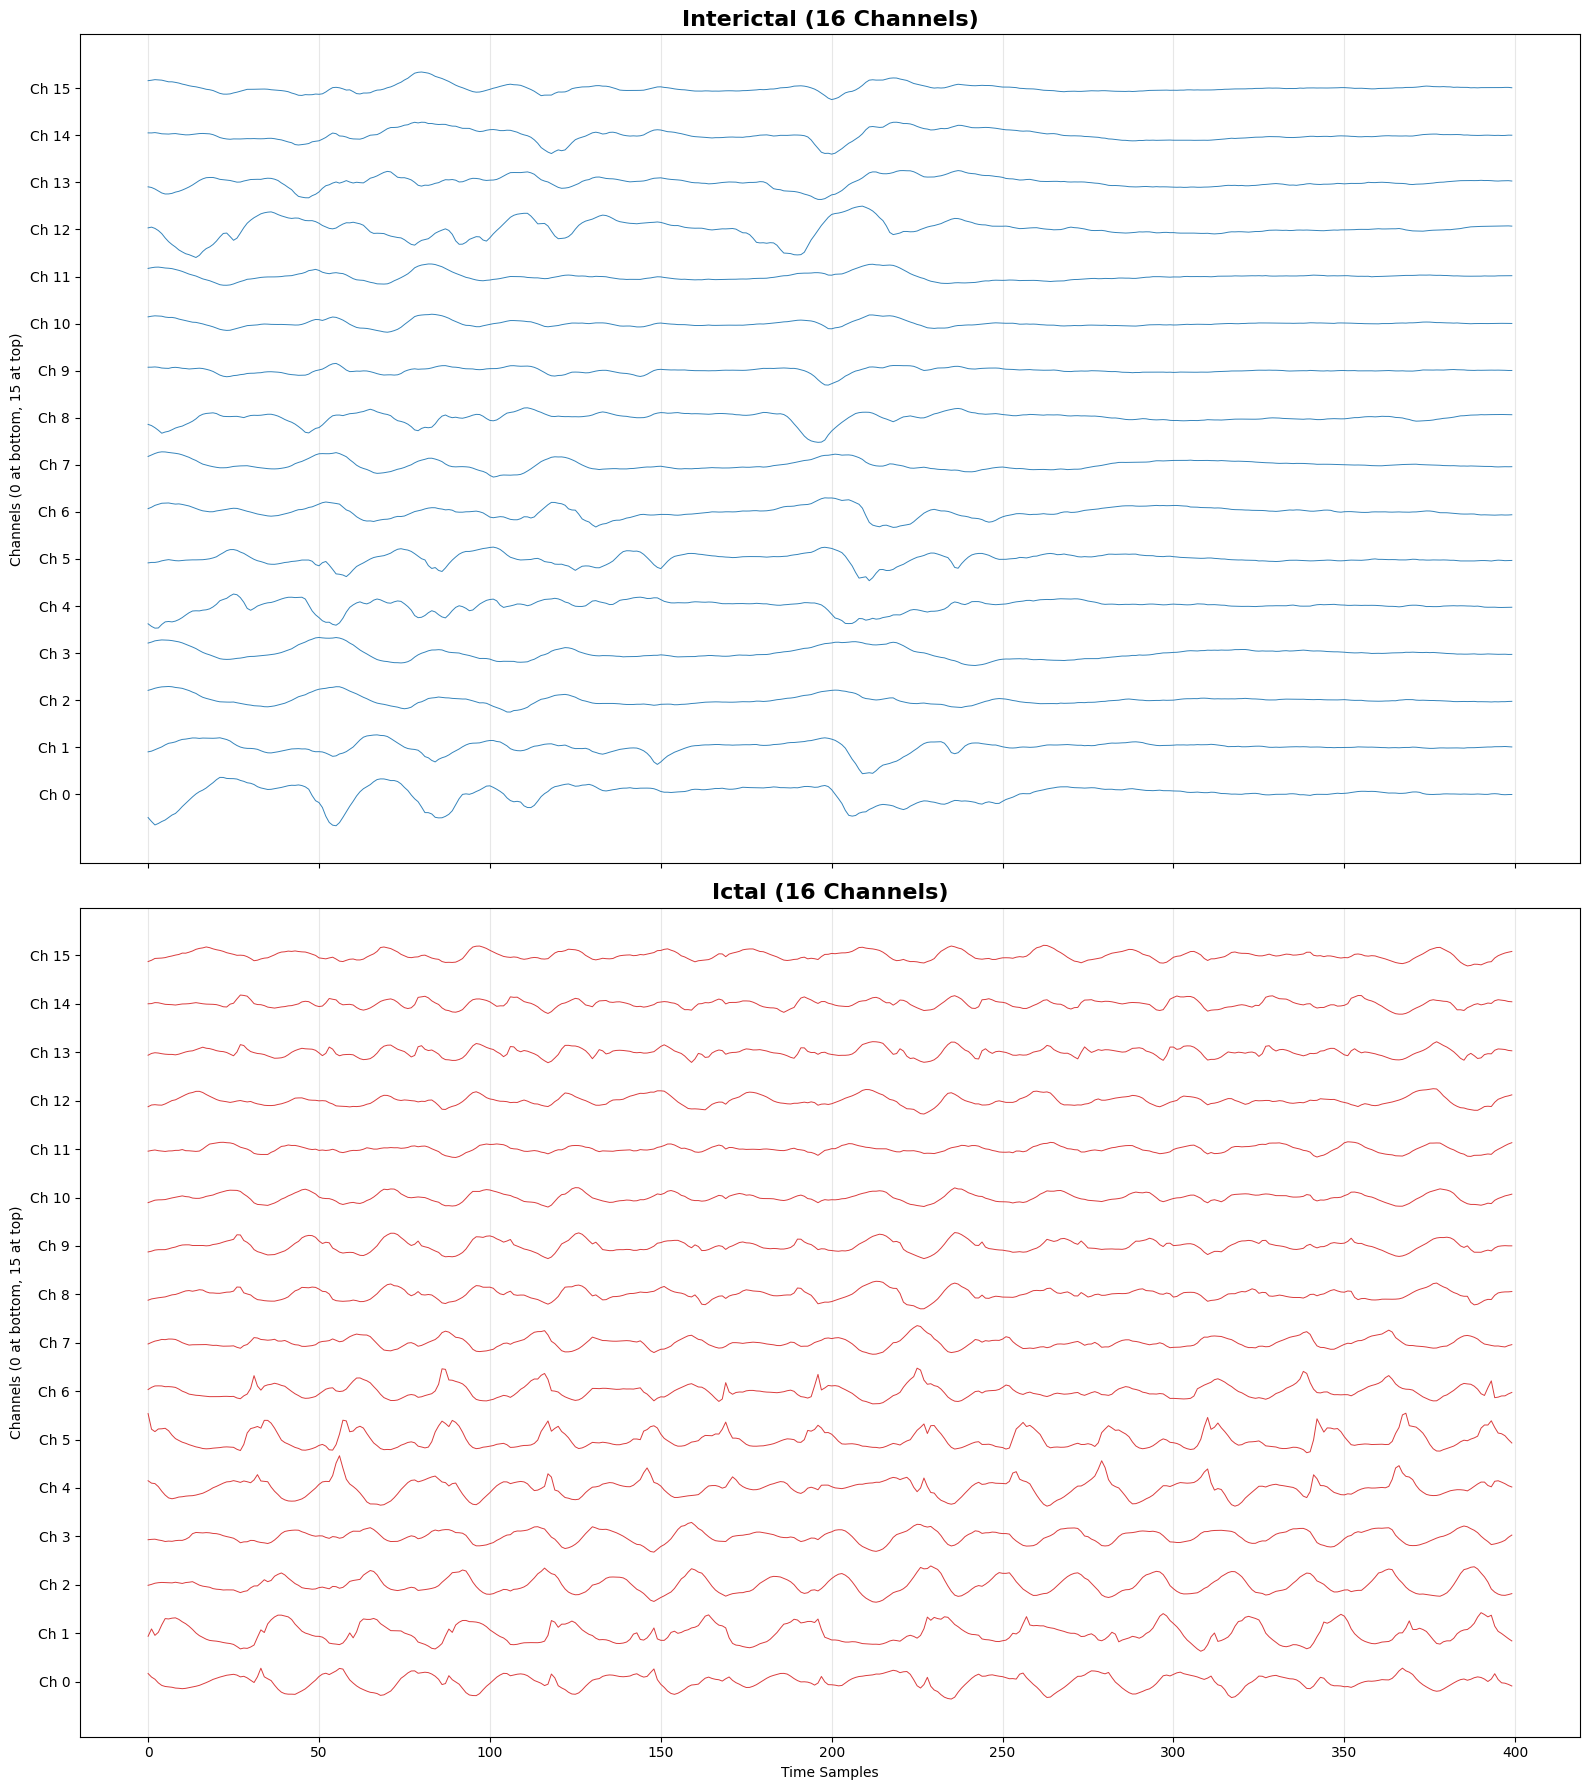

In [3]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

def visualize_all_16_channels(file_paths, labels):
    # 1. Find indices for one Ictal and one Interictal sample
    ictal_idx = labels.index(1.0)
    interictal_idx = labels.index(0.0)

    indices = [interictal_idx, ictal_idx]
    titles = ["Interictal (16 Channels)", "Ictal (16 Channels)"]
    colors = ['#1f77b4', '#d62728'] # Professional Blue and Red

    # Increase figsize height to 18 to accommodate 16 channels
    fig, axes = plt.subplots(2, 1, figsize=(16, 18), sharex=True)

    for i, idx in enumerate(indices):
        mat = loadmat(file_paths[idx])
        data_key = [k for k in mat.keys() if not k.startswith('__')][0]
        signal = mat[data_key]

        # Standardize to (Channels, Time)
        if signal.shape[0] > signal.shape[1]:
            signal = signal.T

        num_channels = signal.shape[0] # Should be 16

        # Calculate a dynamic offset based on the maximum amplitude in the whole signal
        # to prevent lines from overlapping
        max_amp = np.max(np.abs(signal))
        spacing = max_amp * 1.5

        for ch in range(num_channels):
            # Each channel is shifted upward by (channel_index * spacing)
            axes[i].plot(signal[ch] + (ch * spacing), color=colors[i], linewidth=0.7, alpha=0.9)

        axes[i].set_title(titles[i], fontsize=16, fontweight='bold')
        axes[i].set_ylabel("Channels (0 at bottom, 15 at top)")
        axes[i].set_yticks([ch * spacing for ch in range(num_channels)])
        axes[i].set_yticklabels([f"Ch {ch}" for ch in range(num_channels)])
        axes[i].grid(True, axis='x', alpha=0.3)

    plt.xlabel("Time Samples")
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_all_16_channels(file_paths, labels)

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from scipy.io import loadmat
from scipy.signal import spectrogram
from torchvision import models
import cv2
import numpy as np
import os

# --- CREATE STORAGE DIRECTORY ---
SAVE_DIR = '/content/spectrogram_images'
os.makedirs(os.path.join(SAVE_DIR, 'interictal'), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, 'ictal'), exist_ok=True)

class EEGSpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, fs=400, img_size=224, save_images=True):
        self.file_paths = file_paths
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.fs = fs
        self.img_size = img_size
        self.save_images = save_images

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # 1. Load the raw .mat data
        file_path = self.file_paths[idx]
        label = int(self.labels[idx].item())
        file_name = os.path.basename(file_path).replace('.mat', '.png')

        mat = loadmat(file_path)
        key = [k for k in mat.keys() if not k.startswith('__')][0]
        signal = mat[key]
        if signal.shape[0] != 16: signal = signal.T

        # 2. Generate Spectrogram Layers (RGB)
        channels_to_use = [0, 8, 15]
        spec_layers = []
        for ch in channels_to_use:
            f, t, Sxx = spectrogram(signal[ch], fs=self.fs, nperseg=64, noverlap=32)
            Sxx_log = np.log1p(Sxx)
            norm = ((Sxx_log - Sxx_log.min()) / (Sxx_log.max() - Sxx_log.min() + 1e-8) * 255).astype(np.uint8)
            resized = cv2.resize(norm, (self.img_size, self.img_size))
            spec_layers.append(resized)

        # 3. Stack into an RGB Image (224, 224, 3) for saving
        # Note: PyTorch needs (3, 224, 224), but OpenCV/Images need (224, 224, 3)
        rgb_image = np.stack(spec_layers, axis=-1)

        # 4. Save to Disk (Optional)
        if self.save_images:
            sub_folder = 'ictal' if label == 1 else 'interictal'
            dest_path = os.path.join(SAVE_DIR, sub_folder, file_name)
            if not os.path.exists(dest_path): # Only save if it doesn't exist to save time
                cv2.imwrite(dest_path, rgb_image)

        # 5. Return as Tensor for the AI (3, 224, 224)
        torch_img = torch.tensor(rgb_image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        return torch_img, self.labels[idx]

# --- MODEL CLASS (Same as before) ---
class SpectrogramShuffleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.shufflenet_v2_x0_5(weights=models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.backbone(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# 1. Initialize Loaders
train_loader = DataLoader(EEGSpectrogramDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(EEGSpectrogramDataset(X_val, y_val), batch_size=16, shuffle=False)

# 2. Initialize Model, Optimizer, Loss
model = SpectrogramShuffleNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 3. Training Loop
EPOCHS = 10
best_acc = 0.0

print(f"Starting Training on {DEVICE}...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Simple validation check to track progress
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).view(-1, 1)
            preds = (torch.sigmoid(model(inputs)) > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    current_acc = (correct / total) * 100
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {current_acc:.2f}%")

    # Save the best model
    if current_acc > best_acc:
        best_acc = current_acc
        torch.save(model.state_dict(), 'spectrogram_model.pth')
        print("--> Best model saved.")

print("\nTraining Complete.")

Starting Training on cuda...
Epoch 1/10 | Loss: 0.6920 | Val Acc: 47.37%
--> Best model saved.
Epoch 2/10 | Loss: 0.6842 | Val Acc: 47.37%
Epoch 3/10 | Loss: 0.6697 | Val Acc: 87.72%
--> Best model saved.
Epoch 4/10 | Loss: 0.6453 | Val Acc: 85.96%
Epoch 5/10 | Loss: 0.6032 | Val Acc: 85.96%
Epoch 6/10 | Loss: 0.5514 | Val Acc: 85.96%
Epoch 7/10 | Loss: 0.4734 | Val Acc: 85.96%
Epoch 8/10 | Loss: 0.3921 | Val Acc: 85.96%
Epoch 9/10 | Loss: 0.3527 | Val Acc: 85.96%
Epoch 10/10 | Loss: 0.2605 | Val Acc: 85.96%

Training Complete.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Load the best saved weights
test_model = SpectrogramShuffleNet().to(DEVICE)
test_model.load_state_dict(torch.load('spectrogram_model.pth'))
test_model.eval()

all_preds = []
all_probs = []
all_labels = []

print("Running Final Evaluation...")
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = test_model(inputs)

        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(float)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(targets.numpy())

# 2. Display Metrics
print("\n" + "="*30)
print("     FINAL TEST RESULTS")
print("="*30)
print(f"Overall Accuracy: {np.mean(np.array(all_preds).flatten() == np.array(all_labels))*100:.2f}%")
print(f"ROC AUC Score:    {roc_auc_score(all_labels, all_probs):.4f}")
print("-" * 30)
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Interictal', 'Ictal']))

Running Final Evaluation...

     FINAL TEST RESULTS
Overall Accuracy: 87.72%
ROC AUC Score:    0.9481
------------------------------

Confusion Matrix:
[[29  1]
 [ 6 21]]

Classification Report:
              precision    recall  f1-score   support

  Interictal       0.83      0.97      0.89        30
       Ictal       0.95      0.78      0.86        27

    accuracy                           0.88        57
   macro avg       0.89      0.87      0.87        57
weighted avg       0.89      0.88      0.88        57



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from torchvision import models
import cv2
import numpy as np
import os

# --- CONVERTER B DATASET ---
class EEGConverterBDataset(Dataset):
    def __init__(self, file_paths, labels, n_factor=10, img_size=224):
        self.file_paths = file_paths
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.n = n_factor  # Stacking factor from the paper
        self.img_size = img_size

    def apply_converter_b(self, signal):
        """
        Stacks subclips vertically as described in the literature
        to increase the receptive field of the CNN.
        """
        if signal.shape[0] != 16: signal = signal.T # Ensure (16, Time)

        # 1. Calculate length of subclips
        new_time_steps = signal.shape[1] // self.n

        # 2. Slice and stack vertically
        # This creates (16 * n) rows
        subclips = [signal[:, i::self.n][:, :new_time_steps] for i in range(self.n)]
        stacked_img = np.vstack(subclips)

        # 3. Normalize and Resize to 224x224
        norm_img = ((stacked_img - np.min(stacked_img)) / (np.max(stacked_img) - np.min(stacked_img) + 1e-8) * 255).astype(np.uint8)
        resized_img = cv2.resize(norm_img, (self.img_size, self.img_size))

        # 4. Convert to 3 channels for ShuffleNet
        final_img = np.stack([resized_img] * 3, axis=0)
        return final_img

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        mat = loadmat(self.file_paths[idx])
        key = [k for k in mat.keys() if not k.startswith('__')][0]
        signal = mat[key]

        img = self.apply_converter_b(signal)
        return torch.tensor(img, dtype=torch.float32) / 255.0, self.labels[idx]

# --- SHUFFLENET MODEL ---
class ConverterShuffleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.shufflenet_v2_x0_5(weights=models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.backbone(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# 1. Initialize Loaders
train_loader = DataLoader(EEGConverterBDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(EEGConverterBDataset(X_val, y_val), batch_size=16, shuffle=False)

# 2. Initialize Model
conv_model = ConverterShuffleNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(conv_model.parameters(), lr=0.0001)

# 3. Training Loop
EPOCHS = 10
best_acc = 0.0

print(f"Starting Converter B Training on {DEVICE}...")
for epoch in range(EPOCHS):
    conv_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).view(-1, 1)

        optimizer.zero_grad()
        loss = criterion(conv_model(inputs), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    conv_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).view(-1, 1)
            preds = (torch.sigmoid(conv_model(inputs)) > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    current_acc = (correct / total) * 100
    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {current_acc:.2f}%")

    if current_acc > best_acc:
        best_acc = current_acc
        torch.save(conv_model.state_dict(), 'converter_b_model.pth')
        print("--> Best Converter B model saved.")

Starting Converter B Training on cuda...
Epoch 1 | Loss: 0.6876 | Val Acc: 52.63%
--> Best Converter B model saved.
Epoch 2 | Loss: 0.6775 | Val Acc: 52.63%
Epoch 3 | Loss: 0.6572 | Val Acc: 56.14%
--> Best Converter B model saved.
Epoch 4 | Loss: 0.6391 | Val Acc: 77.19%
--> Best Converter B model saved.
Epoch 5 | Loss: 0.5991 | Val Acc: 80.70%
--> Best Converter B model saved.
Epoch 6 | Loss: 0.5481 | Val Acc: 82.46%
--> Best Converter B model saved.
Epoch 7 | Loss: 0.4716 | Val Acc: 78.95%
Epoch 8 | Loss: 0.4219 | Val Acc: 89.47%
--> Best Converter B model saved.
Epoch 9 | Loss: 0.3953 | Val Acc: 87.72%
Epoch 10 | Loss: 0.3247 | Val Acc: 87.72%


In [17]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Load weights
test_model = ConverterShuffleNet().to(DEVICE)
test_model.load_state_dict(torch.load('converter_b_model.pth'))
test_model.eval()

y_true, y_probs, y_preds = [], [], []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = test_model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()

        y_probs.extend(probs)
        y_preds.extend((probs > 0.5).astype(float))
        y_true.extend(targets.numpy())

# 2. Metrics
print("\n" + "="*30)
print("   CONVERTER B TEST RESULTS")
print("="*30)
print(f"Accuracy: {np.mean(np.array(y_preds).flatten() == np.array(y_true))*100:.2f}%")
print(f"ROC AUC:  {roc_auc_score(y_true, y_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_preds, target_names=['Interictal', 'Ictal']))


   CONVERTER B TEST RESULTS
Accuracy: 89.47%
ROC AUC:  0.9358

Classification Report:
              precision    recall  f1-score   support

  Interictal       0.88      0.93      0.90        30
       Ictal       0.92      0.85      0.88        27

    accuracy                           0.89        57
   macro avg       0.90      0.89      0.89        57
weighted avg       0.90      0.89      0.89        57



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from torchvision import models
import cv2
import numpy as np

# --- CONVERTER B DATASET (Same logic as before for fair comparison) ---
class EEGConverterBDataset(Dataset):
    def __init__(self, file_paths, labels, n_factor=10, img_size=224):
        self.file_paths = file_paths
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.n = n_factor
        self.img_size = img_size

    def apply_converter_b(self, signal):
        if signal.shape[0] != 16: signal = signal.T
        new_time_steps = signal.shape[1] // self.n
        subclips = [signal[:, i::self.n][:, :new_time_steps] for i in range(self.n)]
        stacked_img = np.vstack(subclips)
        norm_img = ((stacked_img - np.min(stacked_img)) / (np.max(stacked_img) - np.min(stacked_img) + 1e-8) * 255).astype(np.uint8)
        resized_img = cv2.resize(norm_img, (self.img_size, self.img_size))
        return np.stack([resized_img] * 3, axis=0)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        mat = loadmat(self.file_paths[idx])
        key = [k for k in mat.keys() if not k.startswith('__')][0]
        img = self.apply_converter_b(mat[key])
        return torch.tensor(img, dtype=torch.float32) / 255.0, self.labels[idx]

# --- SCRATCH MODEL (No Pretrained Weights) ---
class ScratchShuffleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # weights=None means the model starts with random noise
        self.backbone = models.shufflenet_v2_x0_5(weights=None)
        self.backbone.fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.backbone(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# 1. Initialize Loaders
train_loader_scratch = DataLoader(EEGConverterBDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader_scratch = DataLoader(EEGConverterBDataset(X_val, y_val), batch_size=16, shuffle=False)

# 2. Initialize Model
scratch_model = ScratchShuffleNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(scratch_model.parameters(), lr=0.0001)

# 3. Training Loop
EPOCHS = 10
best_scratch_acc = 0.0

print(f"Starting Training FROM SCRATCH (No Transfer Learning) on {DEVICE}...")
for epoch in range(EPOCHS):
    scratch_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader_scratch:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).view(-1, 1)

        optimizer.zero_grad()
        loss = criterion(scratch_model(inputs), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    scratch_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader_scratch:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).view(-1, 1)
            preds = (torch.sigmoid(scratch_model(inputs)) > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    current_acc = (correct / total) * 100
    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader_scratch):.4f} | Val Acc: {current_acc:.2f}%")

    if current_acc > best_scratch_acc:
        best_scratch_acc = current_acc
        torch.save(scratch_model.state_dict(), 'scratch_model.pth')
        print("--> Best Scratch model saved.")

Starting Training FROM SCRATCH (No Transfer Learning) on cuda...
Epoch 1 | Loss: 0.6954 | Val Acc: 47.37%
--> Best Scratch model saved.
Epoch 2 | Loss: 0.6628 | Val Acc: 47.37%
Epoch 3 | Loss: 0.6207 | Val Acc: 47.37%
Epoch 4 | Loss: 0.5958 | Val Acc: 63.16%
--> Best Scratch model saved.
Epoch 5 | Loss: 0.5198 | Val Acc: 78.95%
--> Best Scratch model saved.
Epoch 6 | Loss: 0.4784 | Val Acc: 85.96%
--> Best Scratch model saved.
Epoch 7 | Loss: 0.4154 | Val Acc: 85.96%
Epoch 8 | Loss: 0.3959 | Val Acc: 85.96%
Epoch 9 | Loss: 0.3388 | Val Acc: 84.21%
Epoch 10 | Loss: 0.3462 | Val Acc: 82.46%


In [20]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Load weights
final_scratch_model = ScratchShuffleNet().to(DEVICE)
final_scratch_model.load_state_dict(torch.load('scratch_model.pth'))
final_scratch_model.eval()

y_true_s, y_probs_s, y_preds_s = [], [], []

with torch.no_grad():
    for inputs, targets in val_loader_scratch:
        inputs = inputs.to(DEVICE)
        outputs = final_scratch_model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()

        y_probs_s.extend(probs)
        y_preds_s.extend((probs > 0.5).astype(float))
        y_true_s.extend(targets.numpy())

# 2. Metrics
print("\n" + "="*30)
print("   FROM SCRATCH TEST RESULTS")
print("="*30)
print(f"Accuracy: {np.mean(np.array(y_preds_s).flatten() == np.array(y_true_s))*100:.2f}%")
print(f"ROC AUC:  {roc_auc_score(y_true_s, y_probs_s):.4f}")
print("\nClassification Report:")
print(classification_report(y_true_s, y_preds_s, target_names=['Interictal', 'Ictal']))


   FROM SCRATCH TEST RESULTS
Accuracy: 85.96%
ROC AUC:  0.9160

Classification Report:
              precision    recall  f1-score   support

  Interictal       0.89      0.83      0.86        30
       Ictal       0.83      0.89      0.86        27

    accuracy                           0.86        57
   macro avg       0.86      0.86      0.86        57
weighted avg       0.86      0.86      0.86        57



In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def configure_model_layers(model, mode='full'):
    """
    Configures which layers of the model are trainable.
    Modes:
    - 'frozen': Only the final classifier (fc) is trainable.
    - 'partial': Early layers are frozen, but the last stage and fc are trainable.
    - 'full': All layers are trainable (Fine-tuning).
    """
    # First, enable all gradients
    for param in model.parameters():
        param.requires_grad = True

    if mode == 'frozen':
        # Freeze everything except the final classification head
        for name, param in model.backbone.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False
        print("Mode: [FEATURE EXTRACTION] - Only FC layer is trainable.")

    elif mode == 'partial':
        # Freeze early layers (conv1, stage2, stage3)
        # Unfreeze stage4, conv5, and fc
        for name, param in model.backbone.named_parameters():
            if any(x in name for x in ['conv1', 'stage2', 'stage3']):
                param.requires_grad = False
        print("Mode: [PARTIAL FINE-TUNING] - Early layers frozen, later stages trainable.")

    elif mode == 'full':
        print("Mode: [FULL FINE-TUNING] - All layers are trainable.")

    return model

In [22]:
# Assuming X_train, y_train, X_val, y_val and EEGConverterBDataset are already defined

results = {}
modes = ['frozen', 'partial', 'full']

for mode in modes:
    print(f"\n" + "="*40)
    print(f"RUNNING EXPERIMENT: {mode.upper()}")
    print("="*40)

    # 1. Initialize Model and Dataset
    train_loader = DataLoader(EEGConverterBDataset(X_train, y_train), batch_size=16, shuffle=True)
    val_loader = DataLoader(EEGConverterBDataset(X_val, y_val), batch_size=16, shuffle=False)

    model = ConverterShuffleNet().to(DEVICE)
    model = configure_model_layers(model, mode=mode)

    # 2. Setup Optimizer (only for parameters that require grad)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    criterion = nn.BCEWithLogitsLoss()

    # 3. Short Training (5 Epochs is enough to see the trend for Task 6)
    best_acc = 0.0
    for epoch in range(5):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).view(-1, 1)
            optimizer.zero_grad()
            loss = criterion(model(inputs), targets)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).view(-1, 1)
                preds = (torch.sigmoid(model(inputs)) > 0.5).float()
                correct += (preds == targets).sum().item()
                total += targets.size(0)

        acc = (correct / total) * 100
        if acc > best_acc: best_acc = acc
        print(f"Epoch {epoch+1} | Val Acc: {acc:.2f}%")

    results[mode] = best_acc

print("\nTask 6 Experimentation Complete!")


RUNNING EXPERIMENT: FROZEN
Mode: [FEATURE EXTRACTION] - Only FC layer is trainable.
Epoch 1 | Val Acc: 52.63%
Epoch 2 | Val Acc: 52.63%
Epoch 3 | Val Acc: 52.63%
Epoch 4 | Val Acc: 52.63%
Epoch 5 | Val Acc: 57.89%

RUNNING EXPERIMENT: PARTIAL
Mode: [PARTIAL FINE-TUNING] - Early layers frozen, later stages trainable.
Epoch 1 | Val Acc: 47.37%
Epoch 2 | Val Acc: 56.14%
Epoch 3 | Val Acc: 84.21%
Epoch 4 | Val Acc: 82.46%
Epoch 5 | Val Acc: 84.21%

RUNNING EXPERIMENT: FULL
Mode: [FULL FINE-TUNING] - All layers are trainable.
Epoch 1 | Val Acc: 52.63%
Epoch 2 | Val Acc: 52.63%
Epoch 3 | Val Acc: 52.63%
Epoch 4 | Val Acc: 57.89%
Epoch 5 | Val Acc: 71.93%

Task 6 Experimentation Complete!


In [23]:
print("\n" + "="*35)
print("   TASK 6: COMPARISON SUMMARY")
print("="*35)
print(f"{'Configuration':<25} | {'Best Val Acc'}")
print("-" * 35)

for mode, acc in results.items():
    display_name = {
        'frozen': 'Feature Extraction (Frozen)',
        'partial': 'Partial Fine-tuning',
        'full': 'Full Fine-tuning'
    }[mode]
    print(f"{display_name:<25} | {acc:.2f}%")

print("-" * 35)


   TASK 6: COMPARISON SUMMARY
Configuration             | Best Val Acc
-----------------------------------
Feature Extraction (Frozen) | 57.89%
Partial Fine-tuning       | 84.21%
Full Fine-tuning          | 71.93%
-----------------------------------
